In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import preprocessing

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [4]:
train = pd.read_csv('../train_dev_data/modern_train.csv', index_col=0)
# dev = pd.read_csv('../train_dev_data/dev_data.csv')
dev = train[:7000]
train = train[7000:]

# Split off training labels & dev labels
train_labels = train.country_destination
dev_labels = dev.country_destination

# Make the dataset tiny for testing purposes
# train = train[:15000]
# train_labels = train_labels[:15000]

In [5]:
ses = pd.read_csv('../unzipped_files/sessions.csv')
# ses.head()

In [6]:
train.head()

,user_id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,signup_app,first_device_type,first_browser,country_destination,number_visits,number_devices,longest_session,total_time_on_site,action_detail,first_hour
7000,b4amt3o7t1,2014-01-22,20140122013130,MALE,32.0,basic,0,en,direct,direct,...,Web,Mac Desktop,Firefox,US,39.0,1.0,132051.0,488130.0,change_contact_host_dates,1
7001,zyz889qlnv,2014-01-22,20140122013639,MALE,28.0,facebook,0,en,sem-brand,google,...,Web,Windows Desktop,Chrome,NDF,44.0,1.0,88649.0,304046.0,view_search_results,1
7002,y975i3z4uz,2014-01-22,20140122014148,FEMALE,30.0,basic,0,en,sem-brand,google,...,Web,Mac Desktop,Firefox,US,25.0,1.0,364432.0,710668.0,confirm_email_link,1
7003,143wftj6nx,2014-01-22,20140122014507,-unknown-,NaN,basic,0,en,direct,direct,...,Web,Mac Desktop,Safari,ES,70.0,1.0,277635.0,1271871.0,view_search_results,1
7004,0ar0xi9ujt,2014-01-22,20140122014618,FEMALE,27.0,basic,0,en,direct,direct,...,Web,Mac Desktop,Chrome,US,88.0,1.0,184047.0,772708.0,view_search_results,1


In [7]:
def parse_month(col):
    start = col.find("-")
    end = col.find("-", start+1)
    month = col[start+1:end]
    return month

train["month_created"] = train.date_account_created.apply(parse_month)
dev["month_created"] = dev.date_account_created.apply(parse_month)

In [8]:
def parse_season(col):
    if col in ('12', '01', '02'):
        return 'Winter'
    elif col in ('03', '04', '05'):
        return 'Spring'
    elif col in ('06', '07', '08'):
        return 'Summer'
    else:
        return 'Fall'
    
train["season_created"] = train.month_created.apply(parse_season)
dev["season_created"] = dev.month_created.apply(parse_season)

In [9]:
def parse_year(col):
    stop = col.find("-")
    year = col[:stop]
    return year

train["year_created"] = train.date_account_created.apply(parse_year)
dev["year_created"] = dev.date_account_created.apply(parse_year)

In [10]:
def bin_age(col):
    if col >= 65 and col < 100:
        return "100+"
    elif col >=45 and col < 65:
        return "45-65"
    elif col >=30 and col < 45:
        return "30-45"
    elif col >= 0 and col < 30:
        return "Under30"
    else:
        return "Unknown"
    
train["bin_age"] = train.age.apply(bin_age)
dev["bin_age"] = train.age.apply(bin_age)

In [11]:
# REMOVED THIS COLUMN IN MODERN TRAINING SET
# def booking_flag(col):
#     if type(col) != 'str':
#         return 0
#     else:
#         return 1

# train["booking_flag"] = train.date_first_booking.apply(booking_flag)
# dev["booking_flag"] = dev.date_first_booking.apply(booking_flag)

In [13]:
def bin_lang(col):
    if col in ('en', 'zh', 'es', 'fr'):
        return col
    else:
        return 'other'

train["bin_lang"] = train.language.apply(bin_lang)
dev["bin_lang"] = dev.language.apply(bin_lang)

# Test Model 1

In [46]:
# Define a function that will encode columns for decision tree
def label_encode(df, cols):
    le = preprocessing.LabelEncoder()
    for elem in cols:
        df[[elem]] = le.fit_transform(df[[elem]]) 
    return df

# initial crack at columns
# cols = ['age', 'season_created', 'month_created', 'bin_age', 'year_created', 
#         'bin_lang', 'gender','signup_method', 'signup_app', 'first_device_type', 
#         'number_visits', 'number_devices','longest_session', 'total_time_on_site']

# max accuracy = 65.357, predicts 7, 10, 6, 2, 5
cols = ['age', 'season_created', 'month_created','gender','signup_method', 'signup_app', 'first_device_type', 
        'number_visits', 'number_devices','longest_session', 'total_time_on_site']

dt_train = train[cols]
label_encode(dt_train, cols)


dt_dev = dev[cols]
label_encode(dt_dev, cols)

# Preprocess train & dev labels for decision tree
le = preprocessing.LabelEncoder()
dt_train_labels = le.fit_transform(train_labels)
dt_dev_labels = le.fit_transform(dev_labels)

/Users/melaniecostello/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Best score is 0.654 with sample size of 500


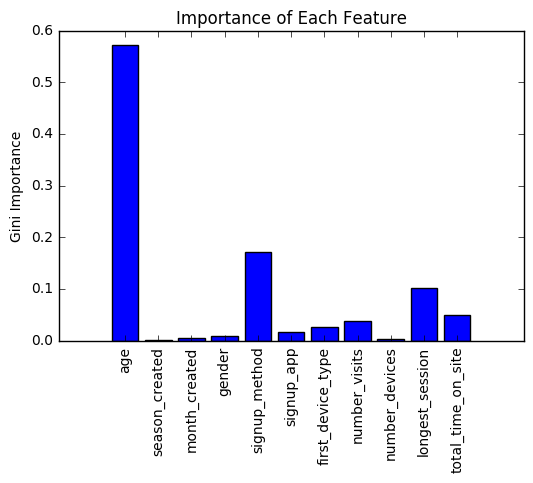

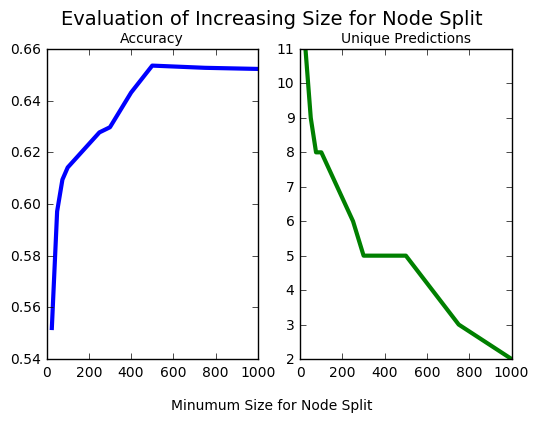

In [110]:
sample_sizes = [25, 50, 75, 100, 250, 300, 400, 500, 750, 1000]
scores = []
max_score = [0, 0]
important_feat = []
num_unique = []
for elem in sample_sizes:
    
    # Fit decision tree model
    dt = DecisionTreeClassifier(criterion="gini", min_samples_split=elem, random_state=99)
    dt.fit(dt_train, dt_train_labels)
    
    # Predict with decision tree
    preds = dt.predict(dt_dev)
    
    # Catalog the unique values & scores predicted for each sample size
    unique = pd.Series(preds).unique()
    num_unique.append(len(unique))
    score = dt.score(dt_dev, dt_dev_labels)
    scores.append(score)
    
    # Track the max score & what sample size was used, as well as
    # the feature importances for the best score
    if score > max_score[1]:
        max_score = [elem, score]
        important_feat = dt.feature_importances_ 

# Output best score
print "Best score is %.3f with sample size of %d" % (max_score[1], max_score[0])

# Create plot to show degree of importance for each feature
num_labels = [c for c in range(len(cols))]
labels = cols
plt.bar(num_labels, important_feat, align='center')
plt.xticks(num_labels, labels, rotation='vertical')
plt.ylabel('Gini Importance')
plt.title("Importance of Each Feature")
plt.show()


# Create plot to show relationship between minimum size for split & accuracy
fig, (ax0, ax1) = plt.subplots(ncols=2)
fig.suptitle("Evaluation of Increasing Size for Node Split", y = 1, fontsize=14)
fig.text(0.5, 0, "Minumum Size for Node Split", ha='center')

ax0.plot(sample_sizes, scores, 'b', label='Accuracy', linewidth=3)
ax0.set_title("Accuracy", fontsize=10)

ax1.plot(sample_sizes, num_unique, 'g', label='Unique Predictions', linewidth=3)
ax1.set_title("Unique Predictions", fontsize=10)

plt.show()

In [32]:
sample_sizes = [75, 100, 250, 500, 750, 1000]
max_depth = [0, 1, 2, 3, 4, 5]
scores = []
for m in max_depth:
    for elem in sample_sizes:
        # Fit decision tree model
        dt = DecisionTreeClassifier(criterion="gini", min_samples_split=elem, random_state=99)
        dt.fit(dt_train, dt_train_labels)
        scores.append((dt.score(dt_dev, dt_dev_labels), m, elem))
        # Predict with decision tree
    #     preds = dt.predict(dt_dev)
scores = sorted(scores)
print scores

[(0.61285714285714288, 0, 75), (0.61285714285714288, 1, 75), (0.61285714285714288, 2, 75), (0.61285714285714288, 3, 75), (0.61285714285714288, 4, 75), (0.61285714285714288, 5, 75), (0.61485714285714288, 0, 100), (0.61485714285714288, 1, 100), (0.61485714285714288, 2, 100), (0.61485714285714288, 3, 100), (0.61485714285714288, 4, 100), (0.61485714285714288, 5, 100), (0.624, 0, 250), (0.624, 1, 250), (0.624, 2, 250), (0.624, 3, 250), (0.624, 4, 250), (0.624, 5, 250), (0.65242857142857147, 0, 1000), (0.65242857142857147, 1, 1000), (0.65242857142857147, 2, 1000), (0.65242857142857147, 3, 1000), (0.65242857142857147, 4, 1000), (0.65242857142857147, 5, 1000), (0.6528571428571428, 0, 750), (0.6528571428571428, 1, 750), (0.6528571428571428, 2, 750), (0.6528571428571428, 3, 750), (0.6528571428571428, 4, 750), (0.6528571428571428, 5, 750), (0.65342857142857147, 0, 500), (0.65342857142857147, 1, 500), (0.65342857142857147, 2, 500), (0.65342857142857147, 3, 500), (0.65342857142857147, 4, 500), (0.6

In [16]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [17]:
# Predict with decision tree
preds = dt.predict(dt_dev)
print dt.score(dt_dev, dt_dev_labels)
print dt.feature_importances_

0.636
[ 0.63443843  0.00687237  0.01237685  0.          0.00369777  0.02509138
  0.03752531  0.19401486  0.03674668  0.04923634]


# Trim features

In [62]:
dt_train = train[['age', 'season_created', 'month_created', 'year_created', 'gender', 
                  'signup_method', 'signup_app', 'first_device_type']]
label_encode(dt_train, ['age', 'season_created', 'month_created', 'year_created', 'gender', 
                        'signup_method', 'signup_app', 'first_device_type'])

dt_dev = dev[['age', 'season_created', 'month_created', 'year_created', 'gender', 
              'signup_method', 'signup_app', 'first_device_type']]
label_encode(dt_dev, ['age', 'season_created', 'month_created', 'year_created', 'gender', 
                      'signup_method', 'signup_app', 'first_device_type'])

/Users/melaniecostello/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,age,season_created,month_created,year_created,gender,signup_method,signup_app,first_device_type
0,31,1,4,3,2,1,2,3
1,23,1,4,4,1,0,2,6
2,2620,1,2,3,0,0,2,3
3,2618,3,1,4,0,0,2,3
4,17,3,0,4,1,0,2,6
5,2617,1,4,3,0,0,2,6
6,30,1,4,4,1,0,2,6
7,8,0,9,3,0,0,3,8
8,2610,3,1,3,0,0,2,3
9,12,2,5,4,1,0,2,8


In [63]:
sample_sizes = [50, 60, 70, 80, 90, 100]
scores = []
for elem in sample_sizes:
    print "min samples: ", elem
     # Fit decision tree model
    dt = DecisionTreeClassifier(criterion="gini", min_samples_split=elem, random_state=99)
    dt.fit(dt_train, dt_train_labels)
    # Predict with decision tree
    preds = dt.predict(dt_dev)
    print dt.score(dt_dev, dt_dev_labels)
    print dt.feature_importances_ 
print pd.Series(preds).unique()

min samples:  50
0.58496
[ 0.58714056  0.01608624  0.08621576  0.06214601  0.02849332  0.12935007
  0.03702348  0.05354456]
min samples:  60
0.5894
[ 0.59384591  0.01605689  0.07652862  0.06198564  0.02809606  0.13853254
  0.03567003  0.0492843 ]
min samples:  70
0.59272
[ 0.60065385  0.015593    0.0680145   0.06155913  0.02849016  0.14517088
  0.03246111  0.04805737]
min samples:  80
0.59036
[ 0.60670319  0.01596219  0.06363447  0.06221003  0.02769316  0.15051434
  0.02927823  0.04400438]
min samples:  90
0.59496
[ 0.60869423  0.015308    0.05885167  0.06156502  0.02801813  0.1583998
  0.02978986  0.03937329]
min samples:  100
0.59612
[ 0.60794866  0.0132112   0.05973006  0.06190021  0.02818757  0.16220467
  0.02930171  0.03751594]
[ 7 10  4  2  5 11  6  0]


# Add sessions data

In [ ]:
ses_agg = pd.read_csv()